# Load modules

We use matplotlib for graphs, scipy and numpy for statistical functions and random distributions, and pyabc for inferring parameter sets. We additionally use line_profiler and memory_profiler to measure code performance.

In [1]:
import os
import tempfile

In [2]:
import copy, random, functools, pickle, math
import numpy as np
import pandas as pd
from multiprocessing import Pool
from scipy import stats
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp

# Simulating cell fates

We define a clone through a record type, where we record when the clone was born (birthtime), when the cell left the clone (lifeTime), the random number generator used to determine the next fate (rng), whether the cell is a stem cell (stem) and the probability of dividing to give daughters with the same cell fate (r). We also include a list of other clones that the clone has given birth to (sibling), and an integer used to assign a unique identity to every cell created (identity). Note we have defined other elements in the record, which we use in future.

In each loop fateSimulate first tests whether the cell has been simulated enough times, and if it has returning a modified version of the last state of the cell. This is either the last state with the lifetime set to the current time (and a Boolean variable, survivor, set to true to indicate this), or if the cell is not a stem cell at the end of the simulation, the last state with the lifetime set to the current time+1.

Next, if the cell is still a stem cell, it creates a new daughter cell as a copy of the parent, with a new unique identity value. We then determine using r and a random number whether the daughter and parent are stem cells after division, defining a new cell to replace the parent and the daughter. Finally, we restart the loop using the replacement cell with the daughter added to the list of siblings.

This however is not sufficient- we want to simulate all the daugter cells as well to see how the clone grows. To do this we define a recursive function cloneSimulateInternal, which simulates a single cell, then recursively runs on all of the daughter cells (and their daughter cells and so on), appending only the key information as a tuple to list reference. This function itself is run through cloneSimulate, which sorts the final list by unique identifier (this is important for later functions).

Finally, the function experiment is defined which takes a list of discrete timepoints, runs cloneSimulate, and asks how many cells are alive at each time.

In [3]:
'''
new model of stem cell (10):
    e = 0
    only symmetrical division: one stem cell and one progenitor cells are produced
    
new model of stem cell (19):
    rand < e:       probability = e,     two stem cells are produced
    e < rand <1:    probability = 1-e,   one stem cell and one progenitor cells are produced
    
new model of progenitor cell (10):
    rand < 0.5:     probability = 0.5,   two stem-like cells are produced 
    rand > 0.5:     probability = 0.5,   two differentiated cells are produced
'''  

class cell:
    def __init__(self,initialCell,stem,epsilon,randomNumberGenerator):
        
        # input variables:
        # initialCell: the birth time point of the initial stem cell or progenitor cell
        # stem: whether this initial cell is a stem-like cell        
        # epsilon: the probability of symmetrical division        
        # randomNumberGenerator: a random number generated between 0 and 1. 
        # Used to be compared with the epsilon, which leads to the fate (stemness) of the daughtor cells (self and sibling)                 
        
        self.currentTime = initialCell
        self.stem = stem
        self.epsilon = epsilon
        self.rng = randomNumberGenerator
        self.lifetime = 0
        self.birthtime = self.currentTime
        self.siblings = []
 
        # variables generated:
        # currentTime: current time point; redefined after each cell division
        # lifetime: the time point of death
        # siblings: a collection of cell fates of all the sibling cells generated from the initial cell
        
    def simulateStemCell(self,maxSimulation):
        
        # input variables:
        # self: the initial cell, including all the parameters e.g. stemness, epsilon
        # maxSimulation: the time point after the maximum number of division of the initial cell 
        # once the currentTime reaches maxSimulation, the division will stop
        
        cont = True
        while(cont):
            if self.lifetime > 0:
                cont = False
            elif self.currentTime>maxSimulation:
                if self.stem:
                    self.lifetime = self.currentTime
                else:
                    self.lifetime = self.currentTime+1
                cont = False
            else:
                if self.stem:
                    self.currentTime += 1
                    sibling = cell(self.currentTime,self.stem,self.epsilon,self.rng)
                    rand = self.rng.random()
                    if rand < self.epsilon:
                        pass
                    else:
                        sibling.stem = False
                    self.siblings.append(sibling)
                else:
                    self.currentTime += 1
                    self.lifetime = self.currentTime
                    
    def simulateProgenitorCell(self,maxSimulation,lossAndDivisionTime):
        
        # input variables:
        # self: the initial cell, including all the parameters e.g. stem-like, epsilon
        # maxSimulation: the time point after the maximum number of division of the initial cell
        # lossAndDivisionTime: the loss-and-division time (the division time of progenitor cells) compared to the division time (the division time of stem cells (1))
        # such that the progenitor cells divide more rapidly than the stem cells
        
        cont = True
        while(cont):
            if self.lifetime > 0:
                cont = False
            elif self.currentTime>maxSimulation:
                if self.stem:
                    self.lifetime = self.currentTime
                else:
                    # the apoptosis time of differentiated cells is about double of the division time of progenitor cells
                    r = random.random()
                    apoptosisTime = lossAndDivisionTime*2*math.log(1/r)
                    self.lifetime = self.currentTime + apoptosisTime
                cont = False
            else:
                # if stem-like cell
                if self.stem:
                    self.currentTime += lossAndDivisionTime
                    sibling = cell(self.currentTime,self.stem,self.epsilon,self.rng)
                    rand = self.rng.random()
                    if rand < 0.5:
                        pass
                    else:
                        self.stem = False
                        sibling.stem = False
                    self.siblings.append(sibling)
                else:
                    # the apoptosis time of differentiated cells is about double of the division time of progenitor cells
                    r = random.random()
                    apoptosisTime = lossAndDivisionTime*2*math.log(1/r)
                    self.currentTime += apoptosisTime
                    self.lifetime = self.currentTime

In [4]:
def simulateStemCloneCore(initialCell,cellFate,parent,nameMarker,maxSimulation):
    
    # input variables:
    # initialCell: the birth time point of each initial stem cell (self and sibling)
    # cellFate: includes birth time, life time, parent, and stemness
    # parent: the birth time point of the parent cell of the initial cell
    # nameMarker: a marker name given to the initial cell
    # maxSimulation: the time point after the maximum number of division of the initial cell 
    
    # simulation for the initial stem cell (self)         
    initialCell.simulateStemCell(maxSimulation)
    nameMarker[0]+=1
    name = nameMarker[0]
    cellFate.append((initialCell.birthtime,
                    initialCell.lifetime,
                    parent,
                    initialCell.stem)) 
    
    # simulation for the sibling cell (self.sibling)
    for sibling in initialCell.siblings:
        simulateStemCloneCore(sibling,cellFate,name,nameMarker,maxSimulation)
        
    # output variables:
    # cellFate: a collection of cell fates of all the cells generated (self and sibling) 
        
    return((cellFate)) 


def simulateStemClone(initialCell,maxSimulation):
    return(simulateStemCloneCore(initialCell=initialCell,cellFate=[],parent=-1,nameMarker=[-1],maxSimulation=maxSimulation))


def simulateProgenitorCloneCore(initialCell,cellFate,parent,nameMarker,maxSimulation,lossAndDivisionTime):
    
    # input variables:
    # initialCell: the birth time point of each initial progenitor cell (self and sibling)
    # cellFate: includes birth time, life time, parent, and stem-like
    # parent: the birth time point of the parent cell of the initial cell
    # nameMarker: a marker name given to the initial cell
    # maxSimulation: the time point after the maximum number of division of the initial cell
    # lossAndDivisionTime: the loss-and-division time (the division time of progenitor cells) compared to the division time (the division time of stem cells (1))
        
    # simulation for the initial progenitor cell (self)         
    initialCell.simulateProgenitorCell(maxSimulation,lossAndDivisionTime)
    nameMarker[0]+=1
    name = nameMarker[0]
    cellFate.append((initialCell.birthtime,
                     initialCell.lifetime,
                     parent,
                     initialCell.stem))
    
    # simulation for the sibling cell (self.sibling)
    for sibling in initialCell.siblings:
        simulateProgenitorCloneCore(sibling,cellFate,name,nameMarker,maxSimulation,lossAndDivisionTime)
    
    # output variables:
    # cellFate: a collection of cell fates of all the cells generated (self and sibling) 
    
    return((cellFate)) 


def simulateProgenitorClone(initialCell,maxSimulation,lossAndDivisionTime):
    return(simulateProgenitorCloneCore(initialCell=initialCell,cellFate=[],parent=-1,nameMarker=[-1],maxSimulation=maxSimulation,lossAndDivisionTime=lossAndDivisionTime))

In [5]:
'''
testing the model (10) of stem cell
epsilon = 0
'''
a = cell(initialCell=0, stem=True, epsilon=0, randomNumberGenerator=random)
testingA = simulateStemClone(initialCell=a,maxSimulation=5)
testingA
# output: cell fate, i.e. (birthtime, lifetime, parent, stem)

[(0, 6, -1, True),
 (1, 2, 0, False),
 (2, 3, 0, False),
 (3, 4, 0, False),
 (4, 5, 0, False),
 (5, 6, 0, False),
 (6, 7, 0, False)]

In [6]:
'''
testing the model (19) of stem cell
'''
b = cell(initialCell=0, stem=True, epsilon=0.5, randomNumberGenerator=random)
testingB = simulateStemClone(initialCell=b,maxSimulation=5)
testingB
# output: cell fate, i.e. (birthtime, lifetime, parent, stem)

[(0, 6, -1, True),
 (1, 6, 0, True),
 (2, 3, 1, False),
 (3, 6, 1, True),
 (4, 6, 3, True),
 (5, 6, 4, True),
 (6, 6, 5, True),
 (6, 6, 4, True),
 (5, 6, 3, False),
 (6, 7, 3, False),
 (4, 5, 1, False),
 (5, 6, 1, False),
 (6, 6, 1, True),
 (2, 6, 0, True),
 (3, 6, 13, True),
 (4, 6, 14, True),
 (5, 6, 15, False),
 (6, 6, 15, True),
 (5, 6, 14, False),
 (6, 7, 14, False),
 (4, 6, 13, True),
 (5, 6, 20, False),
 (6, 7, 20, False),
 (5, 6, 13, False),
 (6, 7, 13, False),
 (3, 6, 0, True),
 (4, 5, 25, False),
 (5, 6, 25, True),
 (6, 7, 27, False),
 (6, 6, 25, True),
 (4, 6, 0, True),
 (5, 6, 30, False),
 (6, 7, 30, False),
 (5, 6, 0, True),
 (6, 7, 33, False),
 (6, 7, 0, False)]

In [7]:
'''
testing the model (10) of progenitor cell
'''
c = cell(initialCell=0, stem=True, epsilon=0.5, randomNumberGenerator=random)
testingC = simulateProgenitorClone(initialCell=c,maxSimulation=5,lossAndDivisionTime = 0.1)
testingC
# output: cell fate, i.e. (birthtime, lifetime, parent, stem)

[(0, 0.38342703902926023, -1, False),
 (0.1, 0.2864748069997468, 0, False),
 (0.2, 0.28776144877550364, 1, False),
 (0.2, 0.4056746962756201, 0, False),
 (0.30000000000000004, 0.4985507849208508, 3, False),
 (0.30000000000000004, 0.3327800600998333, 0, False)]

In [8]:
def fateToCloneSize(clone,countingTimePoint,lossAndDivisionTime):
    
    # input variables:
    # clone: a collection of cell fates of all the cells in a clone 
    # countingTimePoint: the time point selected to count the cells in each clone
    # lossAndDivisionTime: the loss-and-division time (the division time of progenitor cells) compared to the division time (the division time of stem cells (1))
    
    count = 0
    # counting based on birth time and life time of each cell
    
    for (birthtime, lifetime, parent, stem) in clone:
        
        # firstly count the number of stem cells
        if stem == True:
            if birthtime <= countingTimePoint:
                count += 1
            else:
                count += 0
        
        # secondly count the number of progenitor cells
        else:
            maxProgenitorSimulation = countingTimePoint - birthtime
            progenitorCell = cell(initialCell=0,stem=True,epsilon=0.5,randomNumberGenerator=random)
            progenitorClone = simulateProgenitorClone(initialCell=progenitorCell,maxSimulation=maxProgenitorSimulation,lossAndDivisionTime=lossAndDivisionTime)
            
            for (Birthtime, Lifetime, Parent, Stem) in progenitorClone:
                if (birthtime + Birthtime <= countingTimePoint) and (birthtime + Lifetime > countingTimePoint):
                    count += 1
                else:
                    count += 0
    
    # output variable:
    # count: cell count of each clone
    
    return(count)
        
def cloneGenerator(countingTimePoint,epsilon,lossAndDivisionTime,N):
    
    # input variable:
    # countingTimePoint: the time point selected to count the cells in each clone
    # epsilon: the probability of symmetrical division of stem cells
    # lossAndDivisionTime: the loss-and-division time (the division time of progenitor cells) compared to the division time (the division time of stem cells (1))
    # N: the number of parallele tasks
    
    simulation = 1000
    # during each simulaion, a clonal growth is simulated
    maxStemSimulation = countingTimePoint
    def seedWrapper(epsilon,maxSimulation,seed):
        random.seed(seed)
        clone = cell(initialCell=0,stem=True,epsilon=epsilon,randomNumberGenerator=random)
        return(simulateStemClone(initialCell=clone,maxSimulation=maxSimulation))
    fates = np.asarray( [np.asarray(seedWrapper(epsilon,maxStemSimulation,N*1000+seed)) for seed in range(simulation)] )
    return([(fateToCloneSize(clone,countingTimePoint,lossAndDivisionTime)) for clone in fates])

def multiSimulation(N):
    # N: the number of parallele tasks    
    countingTimePoint=5
    epsilon=0.1
    lossAndDivisionTime=0.067
    return(cloneGenerator(countingTimePoint,epsilon,lossAndDivisionTime,N))


In [9]:
from multiprocessing import Pool

if __name__ == '__main__':
    with Pool(2) as p:
        %time results = p.map(multiSimulation, range(2))

CPU times: user 3.22 ms, sys: 1.64 ms, total: 4.86 ms
Wall time: 4.76 s


In [10]:
test = np.concatenate(results)
np.shape(test)

(2000,)

minimum clone size = 2
maximum clone size = 451


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


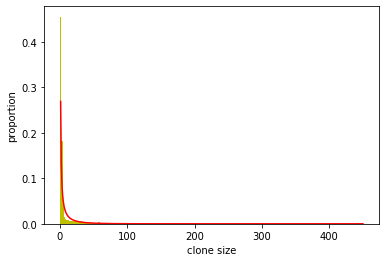

In [11]:
def negativeBinomialDistribution(divisionRate, countingTimePoint, n):
    n0 = divisionRate * countingTimePoint / 2
    N0 = np.log(n0)
    P = 1 / N0 * np.exp(-n/n0) / n
    return(P)

def checkingNegativeBinomialDistribution(cloneSizes,countingTimePoint):
    minimum = min(cloneSizes)
    print('minimum clone size = ' + str(minimum))
    maximum = max(cloneSizes)
    print('maximum clone size = ' + str(maximum))
    sizes = list(np.array(cloneSizes))
    freq = np.asarray([sizes.count(i+1) for i in range(maximum)])
    prob = freq/sum(freq)
    x = np.asarray(range(maximum))
    plt.bar(x,prob,width=2,color='y')
    plt.plot(x, negativeBinomialDistribution(divisionRate=1/0.067, countingTimePoint=countingTimePoint, n=x), 'r')
    plt.xlabel('clone size')
    plt.ylabel('proportion')
#     plt.yscale('log')
    
checkingNegativeBinomialDistribution(cloneSizes=test,countingTimePoint=5)

minimum clone size = 2
maximum clone size = 451


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


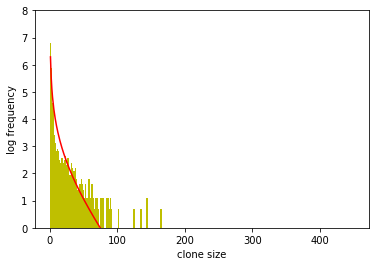

In [12]:
def logSizeDistribution(cloneSizes,countingTimePoint):
    minimum = min(cloneSizes)
    print('minimum clone size = ' + str(minimum))
    maximum = max(cloneSizes)
    print('maximum clone size = ' + str(maximum))
    x = np.asarray(range(maximum))
    sizes = list(np.array(cloneSizes))
    freq = np.asarray([sizes.count(i+1) for i in range(maximum)])
    plt.bar(x,np.log(freq),width=2,color='y') 
    plt.plot(x, np.log(sum(freq)*negativeBinomialDistribution(divisionRate=1/0.067, countingTimePoint=countingTimePoint, n=x)), 'r')
    plt.ylim((0, 8))
    plt.xlabel('clone size')
    plt.ylabel('log frequency')
    
logSizeDistribution(cloneSizes=test,countingTimePoint=5)

In [13]:
# pickle_out = open("pickled_timepoint_15_simulation_10p4","wb")
# pickle.dump(test, pickle_out)
# pickle_out.close()

In [14]:
# pickle_in = open("pickled_timepoint_25","rb")
# cloneSizes = pickle.load(pickle_in)